In [1]:
#import pandas for dataframes, import csv, import os for file handling
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #suppress futurewarnings from matplotlib
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import pandas as pd
from pandas import read_csv
import math
from scipy import stats as st
import csv
import sklearn
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from xgboost import XGBClassifier

global df
csv_name = 'pipeline_outputs_SAY_10-15-2021.csv' #INPUT csv name here
df = pd.read_csv(csv_name) #import csv
df_data = pd.read_csv("data.csv") #second data sheet

df_data.drop(['BMI','Sex'], axis=1,inplace =True)
df = df.merge(df_data, on="subject_id", how = 'left')
for col in df.columns:
    if (('GlobalEfficiency' in col) or ('MaximizedModularity' in col) 
        or ('MeanClusteringCoeff' in col) or ('MeanTotalStrength'in col)
        or ('NetworkCharacteristic' in col) or ('TotalStrength' in col)
        or ('dummyrest' in col) or ('session_id' in col) or ('subject_id' in col)
        or ('dummy_rest' in col) or ('file_name' in col) or ('1back' in col)
        or ('acq_id' in col) or ('anatomical_zstat1' in col) or ('datetime' in col)):
        del df[col]

df['Sex'].replace(['Female','Male'],[0,1],inplace=True)

for col in df.columns:
    if(df[col].isnull().values.any()):
        if(df[col].isnull().sum()>34):
            del(df[col])
    
    
            
df=df.dropna()
df = df._get_numeric_data()

list_outliers = {} #global list of outliers for later use

study_name = "SAY" #INPUT study name
date = "10/15/2021" #INPUT date updated (mm/dd/yyyy)

In [2]:
# X = df.iloc[:,0:df.columns.size].values
# Y = df['fft_stair_us_tester1'].values

#https://towardsdatascience.com/3-essential-ways-to-calculate-feature-importance-in-python-2f9149592155
#preprocess data, X and Y train/test split, scale x values 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df.drop('fft_stair_ds_tester1', axis=1)
X2 = df.drop(['fft_stair_ds_tester1','Sex'], axis=1) #no sex
y = df['fft_stair_ds_tester1']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.2, random_state=42)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

ss2 = StandardScaler()
X2_train_scaled = ss2.fit_transform(X2_train)
X2_test_scaled = ss2.transform(X2_test)

C:\Users\bnish\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:13:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
                             Attribute  Importance
2                                  Sex    0.105352
18                         PatientSize    0.053724
32                           raw_max_b    0.051963
13    MeanStrengthdesikanKillianyscrub    0.038823
33                   raw_neighbor_corr    0.029891
0                                  BMI    0.029641
21                              max_fd    0.028654
44                t1_incoherence_index    0.027200
11  MeanStrengthdesikanKillianydespike    0.027093
20                              RefAmp    0.025352
40                    t1_dice_distance    0.024942
10    MeanStrengthdesikanKillianyaroma    0.024911
19                       P

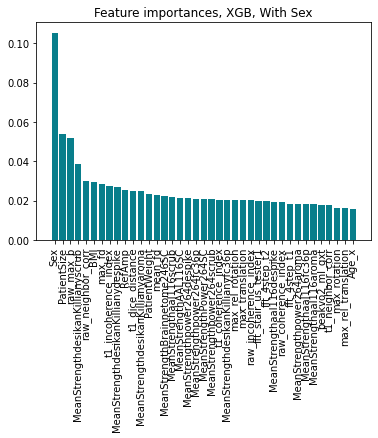

In [3]:
#feature selection using XGB classifier ------ SEX included
model = XGBClassifier()
model.fit(X_train_scaled, y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances.drop(importances.loc[importances['Importance']<0.007].index, inplace=True)
print(importances)
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances, XGB, With Sex')
plt.xticks(rotation='vertical')
plt.show()

C:\Users\bnish\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:13:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
                             Attribute  Importance
17                         PatientSize    0.062410
31                           raw_max_b    0.058497
12    MeanStrengthdesikanKillianyscrub    0.037349
32                   raw_neighbor_corr    0.033109
0                                  BMI    0.032979
20                              max_fd    0.032838
39                    t1_dice_distance    0.030902
18                       PatientWeight    0.030676
9     MeanStrengthdesikanKillianyaroma    0.029191
43                t1_incoherence_index    0.029110
8              MeanStrengthaal116scrub    0.027427
4               MeanStrengthPower264SC    0.026975
10  MeanStrengthdesikanKil

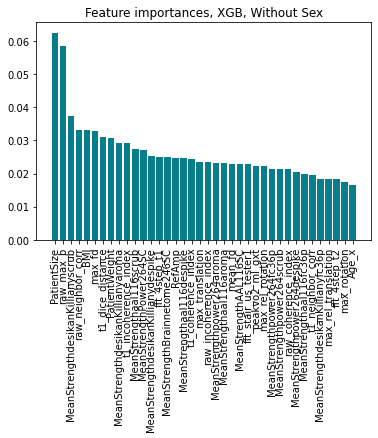

In [4]:
#feature selection using XGB classifier ------ SEX NOT included

model = XGBClassifier()
model.fit(X2_train_scaled, y_train)
importances = pd.DataFrame(data={
    'Attribute': X2_train.columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances.drop(importances.loc[importances['Importance']<0.007].index, inplace=True)
print(importances)
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances, XGB, Without Sex')
plt.xticks(rotation='vertical')
plt.show()

C:\Users\Nishant Bhamidipati\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
C:\Users\Nishant Bhamidipati\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Nishant Bhamidipati\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


dvars_nstd_rest: 27.70570081579798
estimatedLostTemporalDOFaroma: 13.463283463808345
estimatedLostTemporalDOFfc36pscrub: 19.69638535595964
fd_mean_rest: 13.356490892453467
fd_num_rest: 11.006589003826916
fd_perc_rest: 10.938664650006032
nNuisanceParametersaroma: 13.463283463808345
nSpikesFDfc36pscrub: 19.32389991662744
nVolCensoredfc36pscrub: 19.503142594406174
pctSpikesFDfc36pscrub: 19.32389991971171
relMaxRMSMotion: 12.548513144283733
relMaxRMSMotionaroma: 12.548513144283733
relMaxRMSMotionfc36pdespike: 12.548513144283733
relMaxRMSMotionfc36pscrub: 12.548513144283733
relMeanRMSMotion: 16.527861126743584
relMeanRMSMotionaroma: 16.527861126743584
relMeanRMSMotionfc36pdespike: 16.527861126743584
relMeanRMSMotionfc36pscrub: 16.527861126743584
peakvo2_ml_gxt: 14.070035808341949
fft_4step_t1: 11.585328987036307
fft_4step_t2: 10.722206596190558
fft_stair_ds_tester1: 79.12261650265755


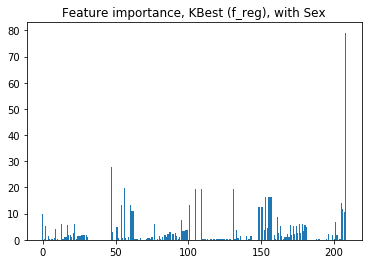

In [5]:
#https://machinelearningmastery.com/feature-selection-for-regression-data/
#feature selection using SelectKBest, f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

def select_features1(X_train, y_train, X_test):
    fs = SelectKBest(score_func=f_regression, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs
 
X_train_fs, X_test_fs, fs = select_features1(X_train, y_train, X_test)
for i in range(len(fs.scores_)):
    if(fs.scores_[i]>10):
        print(df.columns[i]+": "+ str(fs.scores_[i]))
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.title('Feature importance, KBest (f_reg), with Sex')
plt.show()

C:\Users\Nishant Bhamidipati\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
C:\Users\Nishant Bhamidipati\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Nishant Bhamidipati\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


coregJaccardnback: 27.70570081579798
estimatedLostTemporalDOF: 13.463283463808345
estimatedLostTemporalDOFfc36pdespike: 19.69638535595964
fber_t1w: 13.356490892453467
fd_mean_rest: 11.006589003826916
fd_num_rest: 10.938664650006032
nNuisanceParameters: 13.463283463808345
nSpikesDVfc36pscrub: 19.32389991662744
nVolCensoredfc36pdespike: 19.503142594406174
pctSpikesDVfc36pscrub: 19.32389991971171
raw_voxel_size_z: 12.548513144283733
relMaxRMSMotion: 12.548513144283733
relMaxRMSMotionaroma: 12.548513144283733
relMaxRMSMotionfc36pdespike: 12.548513144283733
relMaxRMSMotionnback: 16.527861126743584
relMeanRMSMotion.1: 16.527861126743584
relMeanRMSMotionaroma: 16.527861126743584
relMeanRMSMotionfc36pdespike: 16.527861126743584
Age_y: 14.070035808341949
peakvo2_ml_gxt: 11.585328987036307
fft_4step_t1: 10.722206596190558
fft_4step_t2: 79.12261650265755


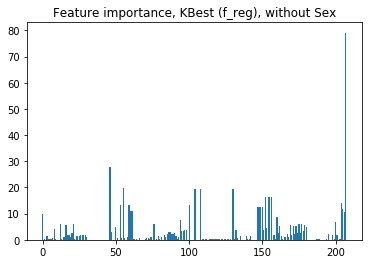

In [6]:
#https://machinelearningmastery.com/feature-selection-for-regression-data/
#feature selection using SelectKBest, f_regression, sex Not Included
def select_features2(X_train, y_train, X_test):
    fs = SelectKBest(score_func=f_regression, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs
 
X_train_fsNoSex, X_test_fsNoSex, fsNoSex = select_features2(X2_train, y_train, X2_test)
for i in range(len(fsNoSex.scores_)):
    if(fsNoSex.scores_[i]>10):
        print(df.columns[i]+": "+ str(fsNoSex.scores_[i]))
plt.bar([i for i in range(len(fsNoSex.scores_))], fsNoSex.scores_)
plt.title('Feature importance, KBest (f_reg), without Sex')
plt.show()

BMI: 0.21464805324597958
MeanStrengthdesikanKillianyaroma: 0.217462282439298
MeanStrengthdesikanKillianyscrub: 0.2134040852891168
MeanStrengthpower264scrub: 0.2008471254416404
dvars_nstd_rest: 0.20117823714574223
estimatedLostTemporalDOFfc36pscrub: 0.30281316156650684
motionDVCorrFinalfc36pscrub: 0.20264341173313305
nSpikesFDfc36pscrub: 0.2994701818338128
nVolCensoredfc36pscrub: 0.25671470663914997
pctSpikesFDfc36pscrub: 0.304852481655451
relMeanRMSMotion: 0.208833012927081
relMeanRMSMotionaroma: 0.208833012927081
relMeanRMSMotionfc36pdespike: 0.208833012927081
relMeanRMSMotionfc36pscrub: 0.208833012927081
fft_stair_ds_tester1: 0.29271070486965245


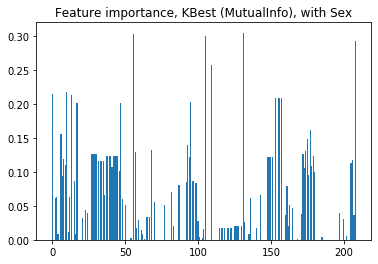

In [7]:
#https://machinelearningmastery.com/feature-selection-for-regression-data/
#feature selection using SelectKBest, mutual_info_regression
from sklearn.feature_selection import mutual_info_regression

def select_features3(X_train, y_train, X_test):
    fs = SelectKBest(score_func=mutual_info_regression, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs
 
X_train_fs2, X_test_fs2, fs2 = select_features3(X_train, y_train, X_test)
for i in range(len(fs2.scores_)):
    if(fs2.scores_[i]>.175):
        print(df.columns[i]+": "+ str(fs2.scores_[i]))
plt.bar([i for i in range(len(fs2.scores_))], fs2.scores_)
plt.title('Feature importance, KBest (MutualInfo), with Sex')
plt.show()

BMI: 0.21587354344205822
MeanStrengthaal116scrub: 0.217462282439298
MeanStrengthdesikanKillianyfc36p: 0.20576519640022806
MeanStrengthpower264fc36p: 0.19529156988608443
coregJaccardnback: 0.19888214509781177
estimatedLostTemporalDOFfc36pdespike: 0.2981414443947896
motionDVCorrFinalfc36pdespike: 0.1950045228442443
nSpikesDVfc36pscrub: 0.30905921242468226
nVolCensoredfc36pdespike: 0.250567295022988
pctSpikesDVfc36pscrub: 0.30681971887085036
relMaxRMSMotionnback: 0.20709690181596985
relMeanRMSMotion.1: 0.20709690181596985
relMeanRMSMotionaroma: 0.20709690181596985
relMeanRMSMotionfc36pdespike: 0.20709690181596985
fft_4step_t2: 0.29635349239401876


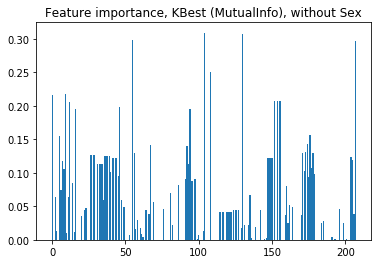

In [8]:
#https://machinelearningmastery.com/feature-selection-for-regression-data/
#feature selection using SelectKBest, mutual_info_regression, Sex Not Included
from sklearn.feature_selection import mutual_info_regression

def select_features4(X_train, y_train, X_test):
    fs = SelectKBest(score_func=mutual_info_regression, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs
 
X_train_fs2NoSex, X_test_fs2NoSex, fs2NoSex = select_features4(X2_train, y_train, X2_test)
for i in range(len(fs2NoSex.scores_)):
    if(fs2NoSex.scores_[i]>.175):
        print(df.columns[i]+": "+ str(fs2NoSex.scores_[i]))
plt.bar([i for i in range(len(fs2NoSex.scores_))], fs2NoSex.scores_)
plt.title('Feature importance, KBest (MutualInfo), without Sex')
plt.show()

In [9]:
#------------------------------------------------------------------------



In [10]:
#Linear Regression, All features (with Sex)
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X_train,y_train)
result = model.predict(X_test)
mae = mean_absolute_error(y_test, result)
mse = mean_squared_error(y_test, result)
print('Mean Absolute Error:'+str(mae))
print('Mean Squared Error:'+str(mse))

Mean Absolute Error:1.8214998697656961
Mean Squared Error:5.580124403970049


In [11]:
def select(X_train, y_train, X_test):
    fs = SelectKBest(score_func=f_regression, k=10)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs
 
model = LinearRegression()
model.fit(X_train_fs, y_train)
result1 = model.predict(X_test_fs)
mae1 = mean_absolute_error(y_test, result1)
mse1 = mean_squared_error(y_test, result1)
print('MAE1: %.3f' % mae1)
print('MSE1: %.3f' % mse1)

model = LinearRegression()
model.fit(X_train_fsNoSex, y_train)
result2 = model.predict(X_test_fsNoSex)
mae2 = mean_absolute_error(y_test, result2)
mse2 = mean_squared_error(y_test, result2)
print('MAE2: %.3f' % mae2)
print('MSE2: %.3f' % mse2)

model = LinearRegression()
model.fit(X_train_fs2, y_train)
result3 = model.predict(X_test_fs2)
mae3 = mean_absolute_error(y_test, result3)
mse3 = mean_squared_error(y_test, result3)
print('MAE3: %.3f' % mae3)
print('MSE3: %.3f' % mse3)

model = LinearRegression()
model.fit(X_train_fs2NoSex, y_train)
result4 = model.predict(X_test_fs2NoSex)
mae4 = mean_absolute_error(y_test, result4)
mse4 = mean_squared_error(y_test, result4)
print('MAE4: %.3f' % mae4)
print('MSE4: %.3f' % mse4)



MAE1: 1.821
MSE1: 5.580
MAE2: 2.022
MSE2: 6.745
MAE3: 1.821
MSE3: 5.580
MAE4: 2.022
MSE4: 6.745


In [12]:
structural = ['fwhm','snr','cnr','fber','efc','qi1','qi2','icvs','rpve','inu','summary']
functional = ['efc','fber','fwhm','ghost_x','snr','dvars','gcor','mean_fd','num_fd','perc_fd','outlier','quality']

X_s = df.copy(deep=True)
for col in X_s.columns:
    flag = True
    for item in structural:
        if (item in col):
            flag = False
    if(flag):
        del X_s[col]
        
X_f = df.copy(deep=True)
for col in X_f.columns:
    flag = True
    for item in functional:
        if (item in col):
            flag = False
    if(flag):
        del X_f[col]

y = df['fft_stair_ds_tester1']
X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_s, y, test_size=0.2, random_state=42)
X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_f, y, test_size=0.2, random_state=42)

ss = StandardScaler()
X_s_train_scaled = ss.fit_transform(X_s_train)
X_s_test_scaled = ss.transform(X_s_test)

ss2 = StandardScaler()
X_f_train_scaled = ss2.fit_transform(X_f_train)
X_f_test_scaled = ss2.transform(X_f_test)

C:\Users\Nishant Bhamidipati\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:20:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
     Attribute  Importance
38     rpve_wm    0.052422
28     icvs_wm    0.043168
47      snr_wm    0.032120
48  snr_wm_t1w    0.030776
21      fwhm_z    0.030522


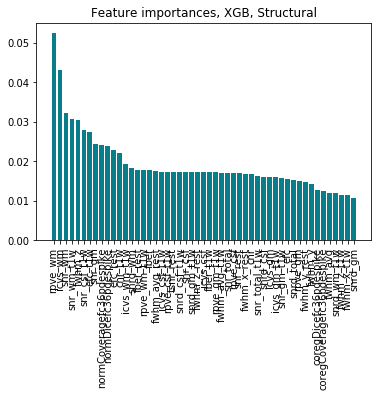

C:\Users\Nishant Bhamidipati\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:20:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
      Attribute  Importance
22       fwhm_z    0.047728
43  snrd_gm_t1w    0.039674
25    gcor_rest    0.034485
9       efc_t1w    0.031411
47  snrd_wm_t1w    0.031312


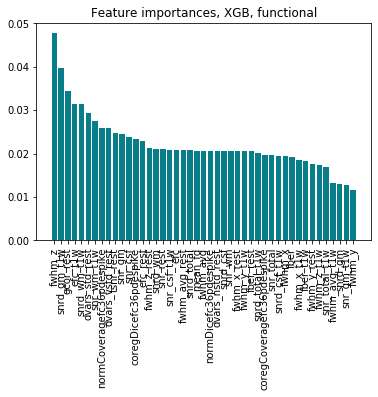

In [13]:
#feature selection using XGB classifier ------ structural and functional
model = XGBClassifier()
model.fit(X_s_train_scaled, y_s_train)
importances_s = pd.DataFrame(data={
    'Attribute': X_s_train.columns,
    'Importance': model.feature_importances_
})
importances_s = importances_s.sort_values(by='Importance', ascending=False)
importances_s.drop(importances_s.loc[importances_s['Importance']<0.01].index, inplace=True)
print(importances_s.head())
plt.bar(x=importances_s['Attribute'], height=importances_s['Importance'], color='#087E8B')
plt.title('Feature importances, XGB, Structural')
plt.xticks(rotation='vertical')
plt.show()

model = XGBClassifier()
model.fit(X_f_train_scaled, y_f_train)
importances_f = pd.DataFrame(data={
    'Attribute': X_f_train.columns,
    'Importance': model.feature_importances_
})
importances_f = importances_f.sort_values(by='Importance', ascending=False)
importances_f.drop(importances_f.loc[importances_f['Importance']<0.01].index, inplace=True)
print(importances_f.head())
plt.bar(x=importances_f['Attribute'], height=importances_f['Importance'], color='#087E8B')
plt.title('Feature importances, XGB, functional')
plt.xticks(rotation='vertical')
plt.show()

In [68]:
#https://machinelearningmastery.com/feature-selection-for-regression-data/
#Regression with tuned number of features
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the pipeline to evaluate
model = LinearRegression()
fs = SelectKBest(score_func=mutual_info_regression)
pipeline = Pipeline(steps=[('sel',fs), ('lr', model)])
# define the grid
grid = dict()
grid['sel__k'] = [i for i in range(X_train.shape[1]-(X_train.shape[1]-1), X_train.shape[1]+1)]
# define the grid search
search = GridSearchCV(pipeline, grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)
# perform the search
results = search.fit(X_train, y_train)
# summarize best
print('Best MAE: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)
# summarize all
means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
    print(">%.3f with: %r" % (mean, param))

Best MAE: -1.186
Best Config: {'sel__k': 1}
>-1.186 with: {'sel__k': 1}
>-1.225 with: {'sel__k': 2}
>-1.217 with: {'sel__k': 3}
>-1.262 with: {'sel__k': 4}
>-1.263 with: {'sel__k': 5}
>-1.306 with: {'sel__k': 6}
>-1.339 with: {'sel__k': 7}
>-1.358 with: {'sel__k': 8}
>-1.381 with: {'sel__k': 9}
>-1.392 with: {'sel__k': 10}
>-1.399 with: {'sel__k': 11}
>-1.396 with: {'sel__k': 12}
>-1.413 with: {'sel__k': 13}
>-1.474 with: {'sel__k': 14}
>-1.511 with: {'sel__k': 15}
>-1.499 with: {'sel__k': 16}
>-1.533 with: {'sel__k': 17}
>-1.529 with: {'sel__k': 18}
>-1.516 with: {'sel__k': 19}
>-1.666 with: {'sel__k': 20}
>-1.805 with: {'sel__k': 21}
>-1.733 with: {'sel__k': 22}
>-1.839 with: {'sel__k': 23}
>-1.772 with: {'sel__k': 24}
>-1.791 with: {'sel__k': 25}
>-1.843 with: {'sel__k': 26}
>-1.858 with: {'sel__k': 27}
>-1.891 with: {'sel__k': 28}
>-1.880 with: {'sel__k': 29}
>-1.933 with: {'sel__k': 30}
>-1.967 with: {'sel__k': 31}
>-1.881 with: {'sel__k': 32}
>-1.853 with: {'sel__k': 33}
>-1.944 

In [69]:
print("Actual    Predicted")
count = 0
for i in y_test:
    print(str(i)+"  "+str(results.predict(X_test)[count]))
    count+=1

Actual    Predicted
7.19  7.600419380049859
9.55  7.158586173761937
7.47  7.512052738792275
10.97  10.450243560606953
7.6  7.136494513447541
8.46  6.930305683846512
5.28  7.482597191706413
7.97  7.622511040364255
6.47  5.825722668126707
6.28  5.685808819468865
6.75  7.276408362105383
5.83  6.908214023532115
7.4  7.917066511222869
6.57  6.657841873302293
7.2  8.660819075140871
8.96  8.196894208538552
6.1  6.333830855357816


In [70]:
#https://machinelearningmastery.com/feature-selection-for-regression-data/
#Regression with tuned number of features NO SEX
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the pipeline to evaluate
model = LinearRegression()
fs = SelectKBest(score_func=mutual_info_regression)
pipeline = Pipeline(steps=[('sel',fs), ('lr', model)])
# define the grid
grid = dict()
grid['sel__k'] = [i for i in range(X2_train.shape[1]-(X2_train.shape[1]-1), X2_train.shape[1]+1)]
# define the grid search
search = GridSearchCV(pipeline, grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)
# perform the search
results = search.fit(X2_train, y_train)
# summarize best
print('Best MAE: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)
# summarize all
means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
    print(">%.3f with: %r" % (mean, param))

Best MAE: -1.186
Best Config: {'sel__k': 1}
>-1.186 with: {'sel__k': 1}
>-1.225 with: {'sel__k': 2}
>-1.215 with: {'sel__k': 3}
>-1.262 with: {'sel__k': 4}
>-1.264 with: {'sel__k': 5}
>-1.326 with: {'sel__k': 6}
>-1.335 with: {'sel__k': 7}
>-1.360 with: {'sel__k': 8}
>-1.383 with: {'sel__k': 9}
>-1.382 with: {'sel__k': 10}
>-1.387 with: {'sel__k': 11}
>-1.409 with: {'sel__k': 12}
>-1.418 with: {'sel__k': 13}
>-1.469 with: {'sel__k': 14}
>-1.488 with: {'sel__k': 15}
>-1.555 with: {'sel__k': 16}
>-1.538 with: {'sel__k': 17}
>-1.466 with: {'sel__k': 18}
>-1.656 with: {'sel__k': 19}
>-1.572 with: {'sel__k': 20}
>-1.638 with: {'sel__k': 21}
>-1.808 with: {'sel__k': 22}
>-1.773 with: {'sel__k': 23}
>-1.693 with: {'sel__k': 24}
>-1.915 with: {'sel__k': 25}
>-1.846 with: {'sel__k': 26}
>-1.866 with: {'sel__k': 27}
>-1.857 with: {'sel__k': 28}
>-1.920 with: {'sel__k': 29}
>-2.000 with: {'sel__k': 30}
>-1.947 with: {'sel__k': 31}
>-1.815 with: {'sel__k': 32}
>-1.879 with: {'sel__k': 33}
>-1.935 

In [71]:
print("Actual    Predicted")
count = 0
for i in y2_test:
    print(str(i)+"  "+str(results.predict(X2_test)[count]))
    count+=1

Actual    Predicted
7.19  7.600419380049859
9.55  7.158586173761937
7.47  7.512052738792275
10.97  10.450243560606953
7.6  7.136494513447541
8.46  6.930305683846512
5.28  7.482597191706413
7.97  7.622511040364255
6.47  5.825722668126707
6.28  5.685808819468865
6.75  7.276408362105383
5.83  6.908214023532115
7.4  7.917066511222869
6.57  6.657841873302293
7.2  8.660819075140871
8.96  8.196894208538552
6.1  6.333830855357816


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeRegressor
rfe = RFE(
    estimator=DecisionTreeRegressor(),
    n_features_to_select=3,
)
model = DecisionTreeRegressor()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
pipeline.fit(X, y)
pipeline.predict(X_test)
count = 0
for i in y_test:
    print(str(i)+"  "+str(pipeline.predict(X_test)[count]))
    count+=1
for i in range(X.shape[1]):
	print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

In [ ]:
#https://machinelearningmastery.com/rfe-feature-selection-in-python/
#code pulled from above website to get best model from Logistic,D

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
def get_models():
	models = dict()
	# lr
	rfe = RFE(estimator=LogisticRegression(), n_features_to_select=5)
	model = DecisionTreeRegressor()
	models['lr'] = Pipeline(steps=[('s',rfe),('m',model)])
	# perceptron
	rfe = RFE(estimator=Perceptron(), n_features_to_select=5)
	model = DecisionTreeRegressor()
	models['per'] = Pipeline(steps=[('s',rfe),('m',model)])
	# cart
	rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=5)
	model = DecisionTreeClassifier()
	models['cart'] = Pipeline(steps=[('s',rfe),('m',model)])
	# rf
	rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=5)
	model = DecisionTreeRegressor()
	models['rf'] = Pipeline(steps=[('s',rfe),('m',model)])
	# gbm
	rfe = RFE(estimator=GradientBoostingRegressor(), n_features_to_select=5)
	model = DecisionTreeRegressor()
	models['gbm'] = Pipeline(steps=[('s',rfe),('m',model)])
	return models
 
def evaluate_model(model, X, y):
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

models = get_models()

results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print(scores)
    print(name+" "+mean(scores)+" "+ std(scores))